# Your first convolutional neural network

# imports

In [1]:
import numpy as np

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 

from keras.datasets import cifar10

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # 避免notebook 执行时退出

Using TensorFlow backend.
/Users/chenwang/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chenwang/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chenwang/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chen

# data

In [2]:
NUM_CLASSES = 10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [5]:
x_train[54, 12, 13, 1] 

0.36862746

# architecture

网络结构如下图所示：

<img src="figures/conv_nets.png" alt="drawing" width="600"/>

- The input shape is (None, 32, 32, 3)
    - None: 任意多的图片（batch）
- 第一层的filter 尺寸是4*4*3
    - Kernel size: 4*4
    - 3 channels：It’s worth remembering that the depth of the filters in a layer is always the same as the number of channels in the preceding layer.
    - 一个kernel 的参数个数是4*4*3+1=49
    - 整层的参数个数：49*10 = 490
    - 第一层的输出是16*16*10
    
通常，当padding=same 的时候，一个conv层输出的tensor shape 是$(None, \frac{input_height}{stride}, \frac{input_width}{stride}, num\_filters)$
    
- 第二层filter 尺寸是3*3*10，共20个filters
    - 参数：（3*3*10+1）*20 = 1,820
    - strides=2, padding=same
    - output: (None,8,8,20)
    
- flatten layer:
    - 输出一个长度为8*8*20 = 1,280 的向量
    - 没有参数
    
- FC layer:
    - 输入：长度为1280 的向量 
    - 输出：10个category
    - 参数个数：12,800

In [ ]:
input_layer = Input(shape=(32,32,3))

conv_layer_1 = Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2
    , padding = 'same'
    )(input_layer)

conv_layer_2 = Conv2D(
    filters = 20
    , kernel_size = (3,3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)

flatten_layer = Flatten()(conv_layer_2)

output_layer = Dense(units=10, activation = 'softmax')(flatten_layer)

model = Model(input_layer, output_layer)

In [ ]:
model.summary()

### batch normalization

#### exploding gradient problem

原因：

- unscaled input could potentially create huge activation values that immediately lead to exploding gradients. 这也是为什么我们需要把每个像素点先标准化到-1～+1之间的原因
- covariate shift: 拿着一堆书的例子。

解决方法：batch normalization

对每一层输入的每个channel做一个normalization，类似于input。There are then two learned parameters for each channel, the scale (gamma) and shift (beta).

We can place batch normalization layers after dense or convolutional layers to normalize the output from those layers.

<img src="figures/batch_normalization.png" alt="drawing" width="300"/>

Test time:

因为一次test 一个样本，有可能没办法做normalization, 所以also calculates the **moving average of the mean and standard deviation** of each channel and stores this value as part of the layer to use at test time. 这两个参数是nontrainable parameters.

所以一个BN layer 一共有4个参数：2个trainable，2个non-trainable.

Keras 中使用Batch Normalization Layer：

```python
BatchNormalization(momentum = 0.9)
```

momentum 计算moving average 时给之前值的权重。 

### dropout

Overfitting -> regularization

dropout layers 是一种解决overfitting 的方法。

reference: Dropout: A Simple Way to Prevent Neural Networks from Overfitting

dropout 一般是接在dense layer 之后使用，因为dense layer 的参数比较多，很容易overfit.

BN 同样有减少overfitting 的作用，所以很多流行的network 不实用dropout，只使用BN 来做Regularization.

In [6]:
input_layer = Input((32,32,3))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 32)        0   

# train

In [8]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 186s 4ms/step - loss: 1.5412 - accuracy: 0.4636 - val_loss: 1.3303 - val_accuracy: 0.5252
Epoch 2/10
50000/50000 [==============================] - 165s 3ms/step - loss: 1.1531 - accuracy: 0.5927 - val_loss: 1.1307 - val_accuracy: 0.5893
Epoch 3/10
50000/50000 [==============================] - 172s 3ms/step - loss: 1.0171 - accuracy: 0.6446 - val_loss: 1.0145 - val_accuracy: 0.6443
Epoch 4/10
50000/50000 [==============================] - 170s 3ms/step - loss: 0.9244 - accuracy: 0.6782 - val_loss: 0.8915 - val_accuracy: 0.6932
Epoch 5/10
50000/50000 [==============================] - 170s 3ms/step - loss: 0.8615 - accuracy: 0.7000 - val_loss: 0.9515 - val_accuracy: 0.6666
Epoch 6/10
50000/50000 [==============================] - 180s 4ms/step - loss: 0.8135 - accuracy: 0.7169 - val_loss: 0.9191 - val_accuracy: 0.6774
Epoch 7/10
50000/50000 [==============================] - 175

In [14]:
model.layers[2].get_weights()

[array([1.0049627 , 1.1082308 , 0.9595764 , 1.0010861 , 1.4464476 ,
        0.9862525 , 1.1199636 , 0.7491369 , 1.1441231 , 1.2955115 ,
        1.0023957 , 0.75194   , 0.87878865, 0.82159257, 1.2121979 ,
        0.9304752 , 0.7770894 , 0.95797235, 0.81247956, 0.8902274 ,
        1.1641147 , 0.77230597, 0.78333056, 0.96611065, 1.0712895 ,
        0.8178045 , 1.194295  , 0.7571858 , 0.9810741 , 1.161705  ,
        1.1242554 , 1.3273948 ], dtype=float32),
 array([ 0.10660601,  0.08919386,  0.04358615,  0.09217341,  0.4553812 ,
         0.4531517 ,  0.54663175, -0.25226235,  0.0247831 ,  0.42097968,
        -0.0506655 , -0.06472366, -0.16808416, -0.02219116, -0.00112522,
         0.03607418, -0.20204397,  0.15577018, -0.13926937, -0.15612845,
         0.09291118, -0.17922322, -0.35279712, -0.05792269,  0.04404805,
        -0.17714383,  0.11118343, -0.25836375,  0.04345207,  0.0543161 ,
         0.01203099,  0.10757452], dtype=float32),
 array([ 0.01934526, -0.05918358, -0.01081633, -0.0738

# analysis

In [15]:
model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 9s 902us/step


[0.9360362529754639, 0.677299976348877]

In [16]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

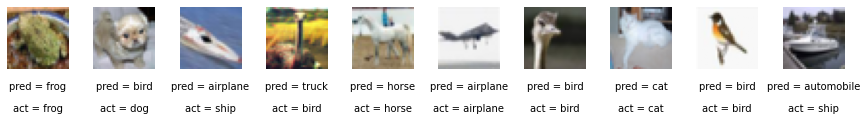

In [17]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


In [18]:
model.save('cnn_model')

In [ ]:
loaded_model = tf.keras.models.load_model('cnn_model')